In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==================== IMPORTS ====================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from typing import Optional, Dict, List

plt.rcParams['figure.figsize'] = (16, 10)
%matplotlib inline

# Global variables
PPC = None
RESULTS = None

print("✅ Libraries loaded")

✅ Libraries loaded


In [ ]:
# ==================== K-MEANS DETECTION WITH VISUALIZATION ====================

def detect_box_kmeans(image: np.ndarray, k: int = 4, visualize: bool = True) -> Optional[Dict]:
    """
    Detect box using K-Means clustering.
    Shows all steps: original → k-means segmentation → each cluster → best detection.
    """
    h, w = image.shape[:2]
    img_area = h * w
    img_cx, img_cy = w / 2, h / 2

    print(f"\n{'='*60}")
    print(f"K-MEANS DETECTION (K={k})")
    print(f"{'='*60}")
    print(f"   Image size: {w} × {h} px")

    # ===== STEP 1: Prepare image =====
    # Apply bilateral filter to reduce noise while keeping edges
    filtered = cv2.bilateralFilter(image, 9, 75, 75)

    # Reshape for k-means
    pixels = filtered.reshape((-1, 3)).astype(np.float32)

    # ===== STEP 2: K-Means clustering =====
    print(f"\n   🔄 Running K-Means with K={k}...")
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape labels back to image shape
    labels = labels.reshape((h, w))
    centers = np.uint8(centers)

    # Create segmented image (each pixel colored by its cluster center)
    segmented = centers[labels.flatten()].reshape(image.shape)

    print(f"   ✅ Found {k} color clusters")
    print(f"\n   Cluster colors (BGR):")
    for i, center in enumerate(centers):
        pixel_count = np.sum(labels == i)
        percentage = pixel_count / img_area * 100
        print(f"      Cluster {i}: BGR={center} ({percentage:.1f}% of image)")

    # ===== STEP 3: Analyze each cluster =====
    all_candidates = []
    cluster_masks = []
    cluster_contours = []

    print(f"\n   🔍 Analyzing each cluster...")

    for cluster_id in range(k):
        # Create binary mask for this cluster
        mask = (labels == cluster_id).astype(np.uint8) * 255

        # Morphological cleaning
        kernel = np.ones((7, 7), np.uint8)
        mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
        mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=2)

        cluster_masks.append(mask_clean)

        # Find contours
        contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        best_contour = None
        best_score = -1

        for cnt in contours:
            area = cv2.contourArea(cnt)

            # Filter by area (2% to 50% of image)
            if area < img_area * 0.02 or area > img_area * 0.50:
                continue

            # Get bounding rectangle
            rect = cv2.minAreaRect(cnt)
            center = rect[0]
            box_w, box_h = rect[1]

            if box_w == 0 or box_h == 0:
                continue

            rect_area = box_w * box_h

            # Metrics
            rectangularity = area / rect_area
            aspect = max(box_w, box_h) / min(box_w, box_h)

            # Polygon approximation
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            num_vertices = len(approx)
            is_convex = cv2.isContourConvex(approx)

            # Filter bad shapes
            if rectangularity < 0.60 or aspect > 5:
                continue

            # ===== SCORING =====
            score = 0

            # Rectangularity (max 30)
            if rectangularity > 0.85:
                score += 30
            elif rectangularity > 0.75:
                score += 22
            elif rectangularity > 0.65:
                score += 15
            else:
                score += 8

            # Vertex count (max 25)
            if num_vertices == 4:
                score += 25
            elif num_vertices in [3, 5]:
                score += 18
            elif num_vertices <= 8:
                score += 10
            else:
                score += 3

            # Aspect ratio (max 15)
            if aspect < 1.5:
                score += 15
            elif aspect < 2.5:
                score += 12
            elif aspect < 4:
                score += 7
            else:
                score += 2

            # Convexity (max 10)
            if is_convex:
                score += 10

            # Center preference (max 20)
            dist_from_center = np.sqrt((center[0] - img_cx)**2 + (center[1] - img_cy)**2)
            max_dist = np.sqrt(img_cx**2 + img_cy**2)
            center_ratio = 1 - (dist_from_center / max_dist)
            score += int(center_ratio * 20)

            if score > best_score:
                best_score = score
                best_contour = {
                    'cluster_id': cluster_id,
                    'contour': cnt,
                    'box_points': np.int32(cv2.boxPoints(rect)),
                    'rect': rect,
                    'center': center,
                    'width_px': max(box_w, box_h),
                    'height_px': min(box_w, box_h),
                    'area': area,
                    'score': score,
                    'rectangularity': rectangularity,
                    'aspect': aspect,
                    'vertices': num_vertices,
                    'is_convex': is_convex
                }

        cluster_contours.append(best_contour)

        if best_contour:
            all_candidates.append(best_contour)
            print(f"      Cluster {cluster_id}: ✅ Found rectangle (score={best_score}, {best_contour['width_px']:.0f}×{best_contour['height_px']:.0f} px)")
        else:
            print(f"      Cluster {cluster_id}: ❌ No valid rectangle")

    # ===== STEP 4: Select best detection =====
    if not all_candidates:
        print("\n   ❌ No valid rectangles found in any cluster!")
        return None

    # Sort by score and get best
    all_candidates.sort(key=lambda x: x['score'], reverse=True)
    best = all_candidates[0]

    print(f"\n   🏆 BEST DETECTION:")
    print(f"      Cluster:       {best['cluster_id']}")
    print(f"      Score:         {best['score']}")
    print(f"      Size:          {best['width_px']:.1f} × {best['height_px']:.1f} px")
    print(f"      Rectangularity: {best['rectangularity']:.3f}")
    print(f"      Vertices:      {best['vertices']}")
    print(f"      Aspect ratio:  {best['aspect']:.2f}")
    print(f"      Convex:        {best['is_convex']}")

    # ===== VISUALIZATION =====
    if visualize:
        # Row 1: Original, Filtered, Segmented
        # Row 2: Cluster masks (up to 4)
        # Row 3: Cluster detections + Final result

        fig = plt.figure(figsize=(20, 15))

        # Row 1: Original → Filtered → Segmented
        ax1 = fig.add_subplot(3, 4, 1)
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax1.set_title('1. Original Image', fontsize=12, fontweight='bold')
        ax1.axis('off')

        ax2 = fig.add_subplot(3, 4, 2)
        ax2.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
        ax2.set_title('2. Bilateral Filtered', fontsize=12, fontweight='bold')
        ax2.axis('off')

        ax3 = fig.add_subplot(3, 4, 3)
        ax3.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
        ax3.set_title(f'3. K-Means Segmented (K={k})', fontsize=12, fontweight='bold')
        ax3.axis('off')

        # Color palette visualization
        ax4 = fig.add_subplot(3, 4, 4)
        palette = np.zeros((50, k*50, 3), dtype=np.uint8)
        for i, color in enumerate(centers):
            palette[:, i*50:(i+1)*50] = color
        ax4.imshow(cv2.cvtColor(palette, cv2.COLOR_BGR2RGB))
        ax4.set_title('4. Cluster Colors', fontsize=12, fontweight='bold')
        ax4.set_xticks([25 + i*50 for i in range(k)])
        ax4.set_xticklabels([f'C{i}' for i in range(k)])
        ax4.set_yticks([])

        # Row 2: Cluster masks
        for i in range(min(k, 4)):
            ax = fig.add_subplot(3, 4, 5 + i)
            ax.imshow(cluster_masks[i], cmap='gray')
            title = f'5.{i+1}. Cluster {i} Mask'
            if cluster_contours[i]:
                title += f'\n(Score: {cluster_contours[i]["score"]})'
            ax.set_title(title, fontsize=11, fontweight='bold' if cluster_contours[i] and cluster_contours[i]['cluster_id'] == best['cluster_id'] else 'normal')
            ax.axis('off')

        # Row 3: Detections on each cluster + Final
        colors = [(0,255,0), (255,255,0), (0,255,255), (255,0,255)]
        for i in range(min(k, 3)):
            ax = fig.add_subplot(3, 4, 9 + i)
            img_show = image.copy()
            if cluster_contours[i]:
                cv2.drawContours(img_show, [cluster_contours[i]['box_points']], -1, colors[i % 4], 3)
                cx, cy = int(cluster_contours[i]['center'][0]), int(cluster_contours[i]['center'][1])
                cv2.circle(img_show, (cx, cy), 8, (0, 0, 255), -1)
            ax.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
            ax.set_title(f'6.{i+1}. Cluster {i} Detection', fontsize=11)
            ax.axis('off')

        # Final result
        ax_final = fig.add_subplot(3, 4, 12)
        img_final = image.copy()
        cv2.drawContours(img_final, [best['box_points']], -1, (0, 255, 0), 4)
        cx, cy = int(best['center'][0]), int(best['center'][1])
        cv2.circle(img_final, (cx, cy), 10, (255, 0, 0), -1)
        ax_final.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
        ax_final.set_title(f'🏆 FINAL: Cluster {best["cluster_id"]}\n{best["width_px"]:.0f}×{best["height_px"]:.0f} px (Score={best["score"]})',
                          fontsize=12, fontweight='bold', color='green')
        ax_final.axis('off')

        plt.tight_layout()
        plt.show()

    return {
        'method': 'kmeans',
        'cluster_id': best['cluster_id'],
        'score': best['score'],
        'width_px': best['width_px'],
        'height_px': best['height_px'],
        'contour': best['box_points'],
        'rect': best['rect'],
        'center': best['center'],
        'area': best['area'],
        'rectangularity': best['rectangularity'],
        'aspect': best['aspect'],
        'vertices': best['vertices']
    }

print("✅ K-Means detection function ready")

✅ K-Means detection function ready


---
## 🎯 PART 1: Calibration

In [ ]:
# ==================== CALIBRATION CONFIG ====================

CALIBRATION_IMAGE = "/content/drive/MyDrive/estimation du volume de colis/calb.jpeg"  # <-- Your calibration image

# Real dimensions of the calibration box face (cm)
CALIB_WIDTH_CM = 8
CALIB_HEIGHT_CM = 8

# K-Means parameter (try 3, 4, or 5)
K_CLUSTERS = 4

print(f"📐 Calibration box: {CALIB_WIDTH_CM} × {CALIB_HEIGHT_CM} cm")
print(f"🔢 K-Means clusters: {K_CLUSTERS}")

📐 Calibration box: 8 × 8 cm
🔢 K-Means clusters: 4


✅ Loaded: 1280×960 px

K-MEANS DETECTION (K=4)
   Image size: 1280 × 960 px

   🔄 Running K-Means with K=4...
   ✅ Found 4 color clusters

   Cluster colors (BGR):
      Cluster 0: BGR=[167 165 162] (32.9% of image)
      Cluster 1: BGR=[144 148 149] (43.4% of image)
      Cluster 2: BGR=[84 30 27] (6.0% of image)
      Cluster 3: BGR=[116 127 134] (17.7% of image)

   🔍 Analyzing each cluster...
      Cluster 0: ❌ No valid rectangle
      Cluster 1: ❌ No valid rectangle
      Cluster 2: ✅ Found rectangle (score=98, 283×280 px)
      Cluster 3: ❌ No valid rectangle

   🏆 BEST DETECTION:
      Cluster:       2
      Score:         98
      Size:          283.1 × 280.2 px
      Rectangularity: 0.973
      Vertices:      4
      Aspect ratio:  1.01
      Convex:        True


/tmp/ipython-input-3428121828.py:254: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


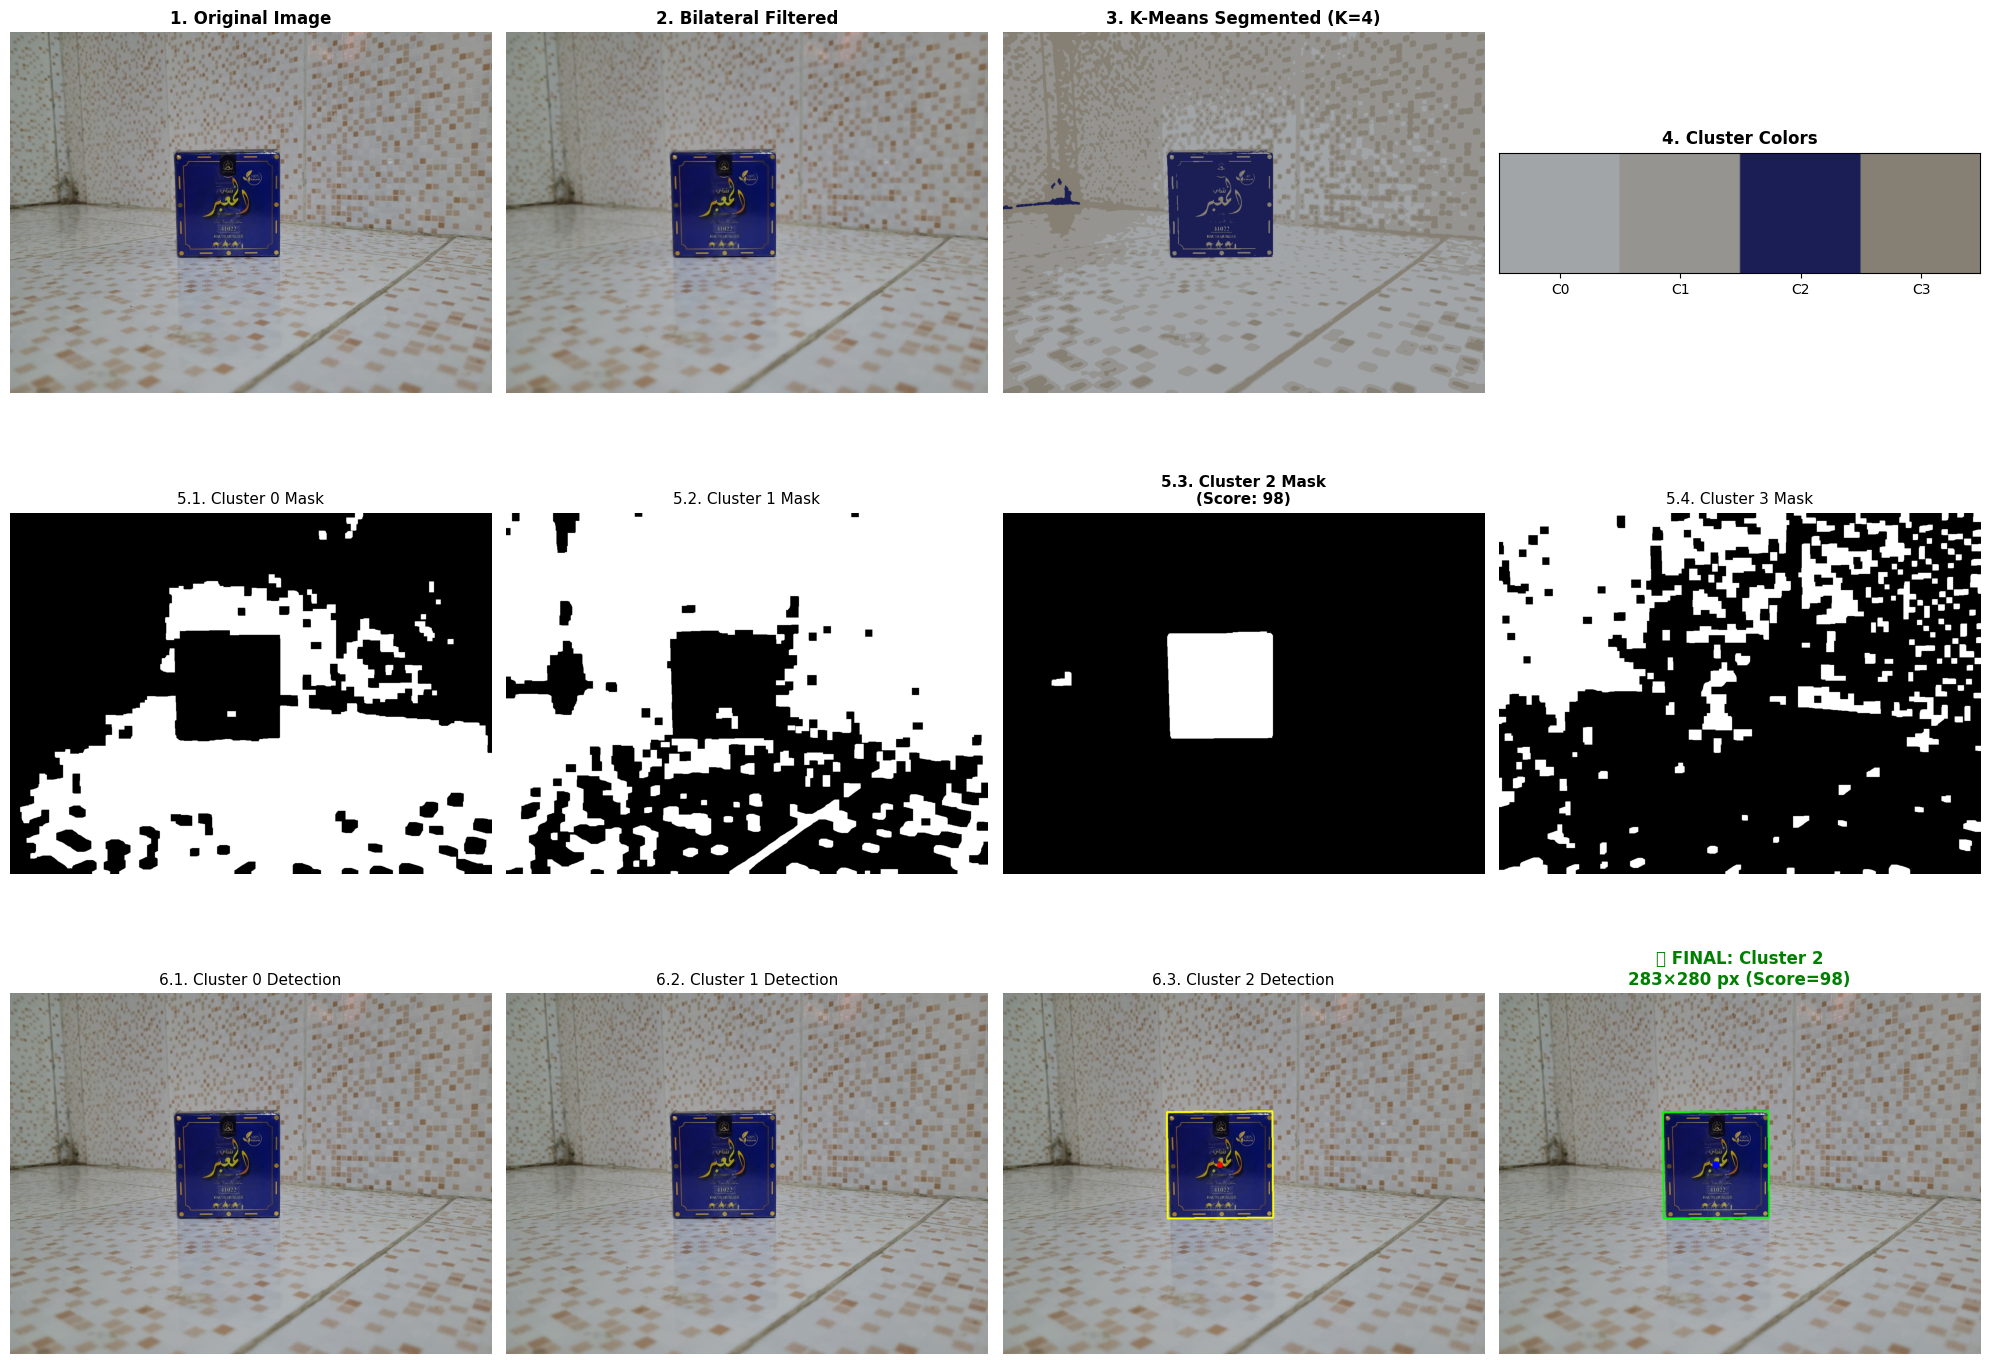


🎯 CALIBRATION SUCCESS
   Detected:  283.1 × 280.2 px
   Real:      8 × 8 cm
   PPC (X):   35.39 px/cm
   PPC (Y):   35.02 px/cm
   PPC (avg): 35.21 px/cm


In [ ]:
# ==================== RUN CALIBRATION ====================

calib_img = cv2.imread(CALIBRATION_IMAGE)

if calib_img is None:
    print(f"❌ Cannot load: {CALIBRATION_IMAGE}")
else:
    print(f"✅ Loaded: {calib_img.shape[1]}×{calib_img.shape[0]} px")

    calib_det = detect_box_kmeans(calib_img, k=K_CLUSTERS, visualize=True)

    if calib_det:
        ppc_x = calib_det['width_px'] / CALIB_WIDTH_CM
        ppc_y = calib_det['height_px'] / CALIB_HEIGHT_CM
        PPC = (ppc_x + ppc_y) / 2

        print(f"\n{'='*60}")
        print("🎯 CALIBRATION SUCCESS")
        print(f"{'='*60}")
        print(f"   Detected:  {calib_det['width_px']:.1f} × {calib_det['height_px']:.1f} px")
        print(f"   Real:      {CALIB_WIDTH_CM} × {CALIB_HEIGHT_CM} cm")
        print(f"   PPC (X):   {ppc_x:.2f} px/cm")
        print(f"   PPC (Y):   {ppc_y:.2f} px/cm")
        print(f"   PPC (avg): {PPC:.2f} px/cm")
        print(f"{'='*60}")
    else:
        print("\n❌ Calibration failed. Try different K value or image.")
        print("   Set PPC manually: PPC = 50.0")

---
## 📏 PART 2: Measure Unknown Box

In [ ]:
# ==================== MEASUREMENT CONFIG ====================

IMAGE_FRONT = "/content/drive/MyDrive/estimation du volume de colis/topn.jpeg"   # Front face (Length × Height)
IMAGE_SIDE = "/content/drive/MyDrive/estimation du volume de colis/siden.jpeg"    # Side face (Width × Height)

# Real dimensions for validation (set all to None if unknown)
REAL_L = 8.20
REAL_W = 18.40
REAL_H = 5.50

# K-Means parameter for measurement
K_MEASURE = 4

print(f"📸 Front: {IMAGE_FRONT}")
print(f"📸 Side:  {IMAGE_SIDE}")
print(f"🔢 K-Means: {K_MEASURE}")

📸 Front: /content/drive/MyDrive/estimation du volume de colis/topn.jpeg
📸 Side:  /content/drive/MyDrive/estimation du volume de colis/siden.jpeg
🔢 K-Means: 4



######################################################################
#                         FRONT FACE                         #
######################################################################

K-MEANS DETECTION (K=4)
   Image size: 1280 × 960 px

   🔄 Running K-Means with K=4...
   ✅ Found 4 color clusters

   Cluster colors (BGR):
      Cluster 0: BGR=[120 129 136] (19.6% of image)
      Cluster 1: BGR=[167 165 162] (28.9% of image)
      Cluster 2: BGR=[148 149 149] (46.3% of image)
      Cluster 3: BGR=[ 42  92 121] (5.2% of image)

   🔍 Analyzing each cluster...
      Cluster 0: ❌ No valid rectangle
      Cluster 1: ❌ No valid rectangle
      Cluster 2: ❌ No valid rectangle
      Cluster 3: ✅ Found rectangle (score=98, 281×194 px)

   🏆 BEST DETECTION:
      Cluster:       3
      Score:         98
      Size:          281.2 × 193.6 px
      Rectangularity: 0.974
      Vertices:      4
      Aspect ratio:  1.45
      Convex:        True


/tmp/ipython-input-3428121828.py:254: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


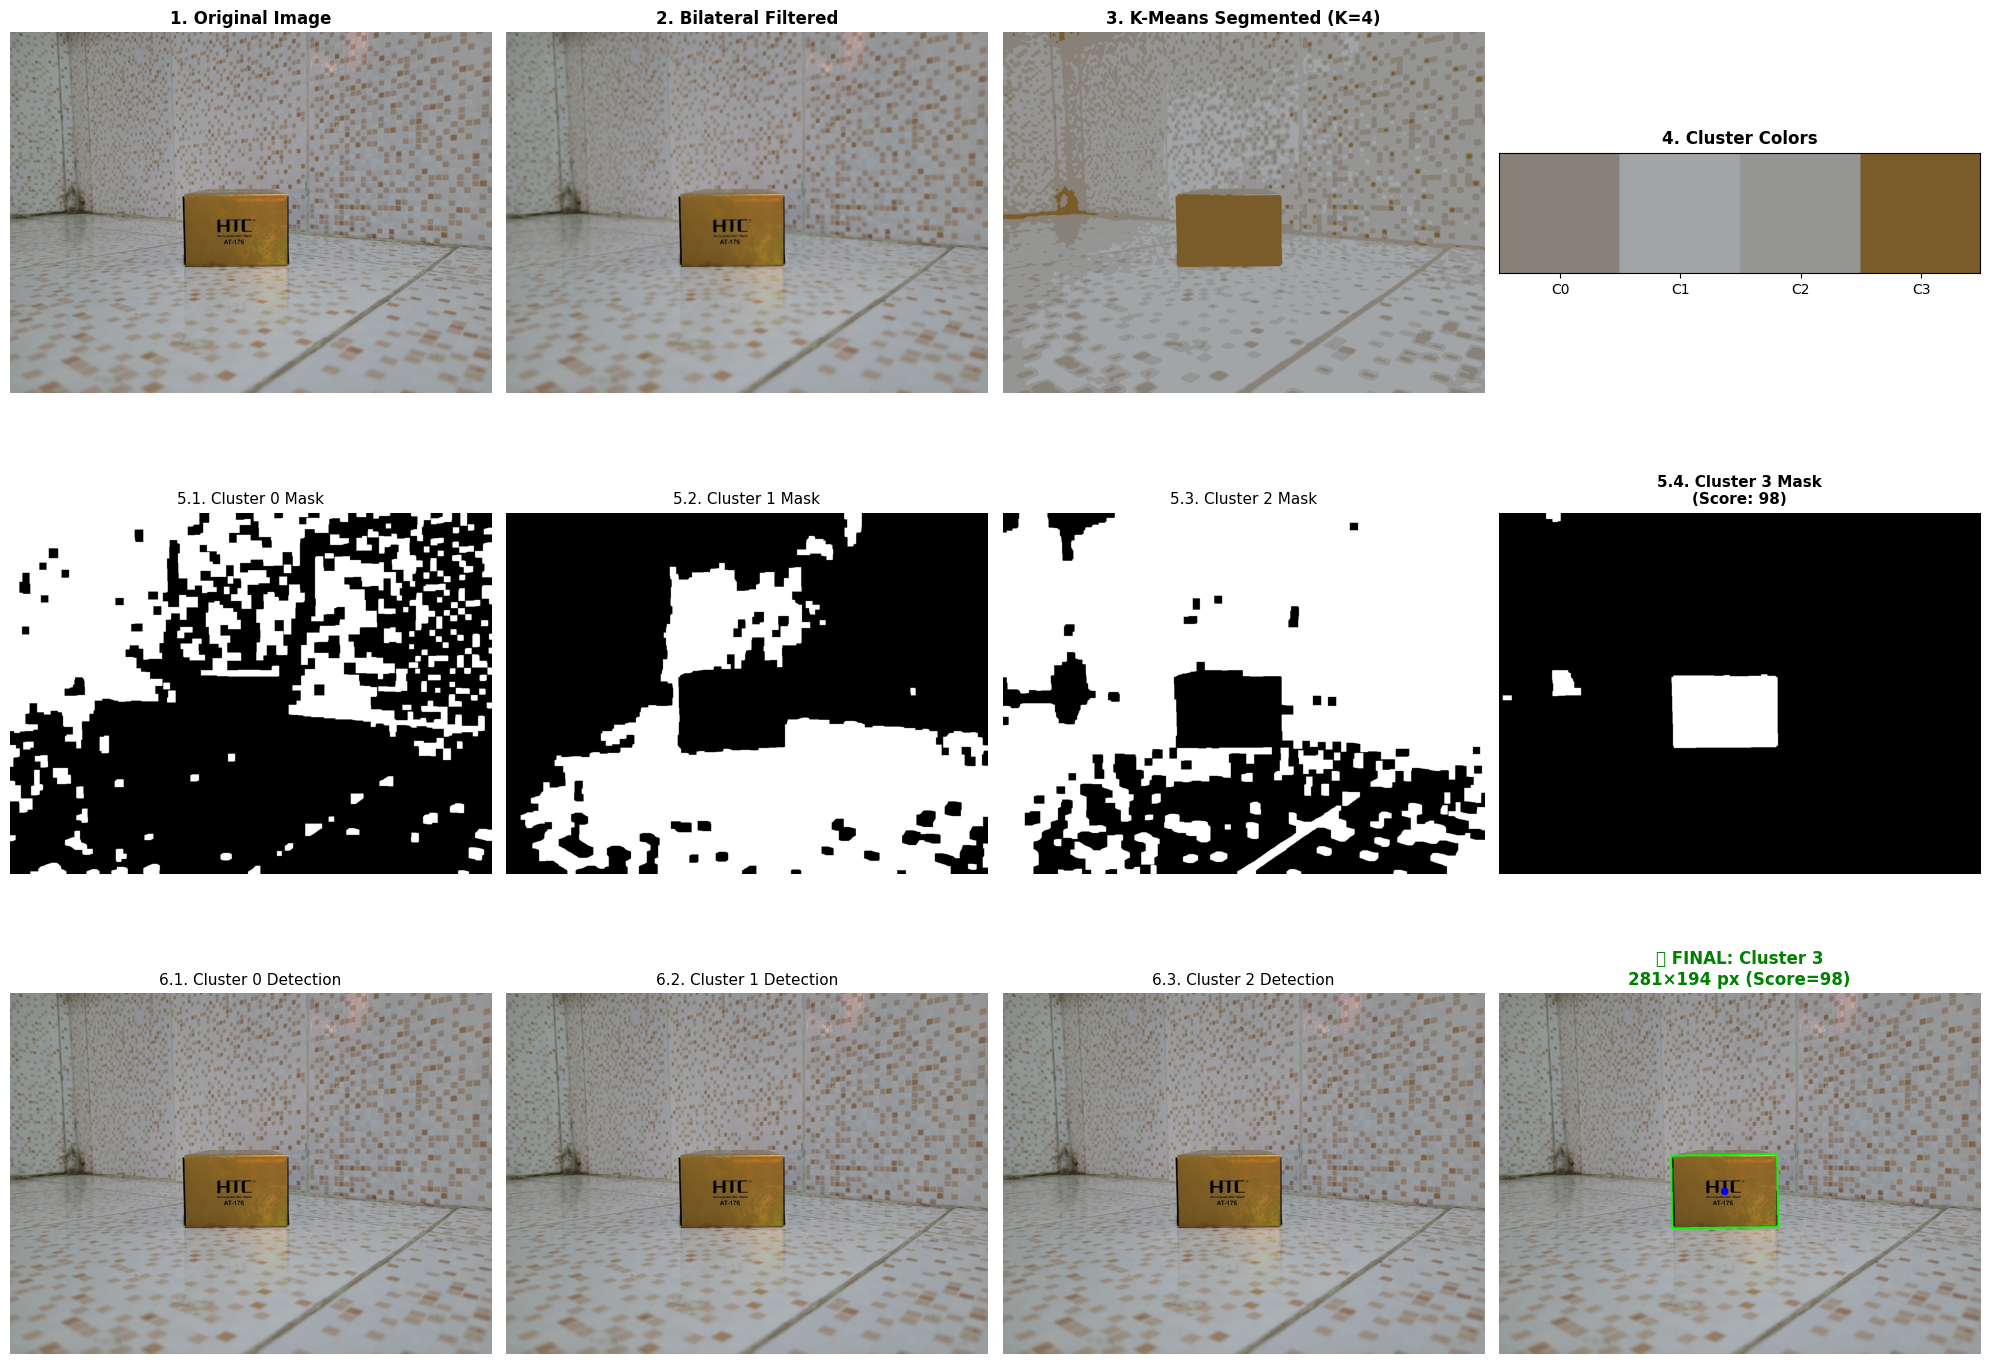


######################################################################
#                         SIDE FACE                          #
######################################################################

K-MEANS DETECTION (K=4)
   Image size: 1280 × 960 px

   🔄 Running K-Means with K=4...
   ✅ Found 4 color clusters

   Cluster colors (BGR):
      Cluster 0: BGR=[119 131 140] (13.6% of image)
      Cluster 1: BGR=[151 155 156] (43.2% of image)
      Cluster 2: BGR=[22 21 23] (9.3% of image)
      Cluster 3: BGR=[173 170 167] (33.9% of image)

   🔍 Analyzing each cluster...
      Cluster 0: ❌ No valid rectangle
      Cluster 1: ❌ No valid rectangle
      Cluster 2: ✅ Found rectangle (score=90, 623×194 px)
      Cluster 3: ❌ No valid rectangle

   🏆 BEST DETECTION:
      Cluster:       2
      Score:         90
      Size:          623.0 × 194.0 px
      Rectangularity: 0.980
      Vertices:      4
      Aspect ratio:  3.21
      Convex:        True


/tmp/ipython-input-3428121828.py:254: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


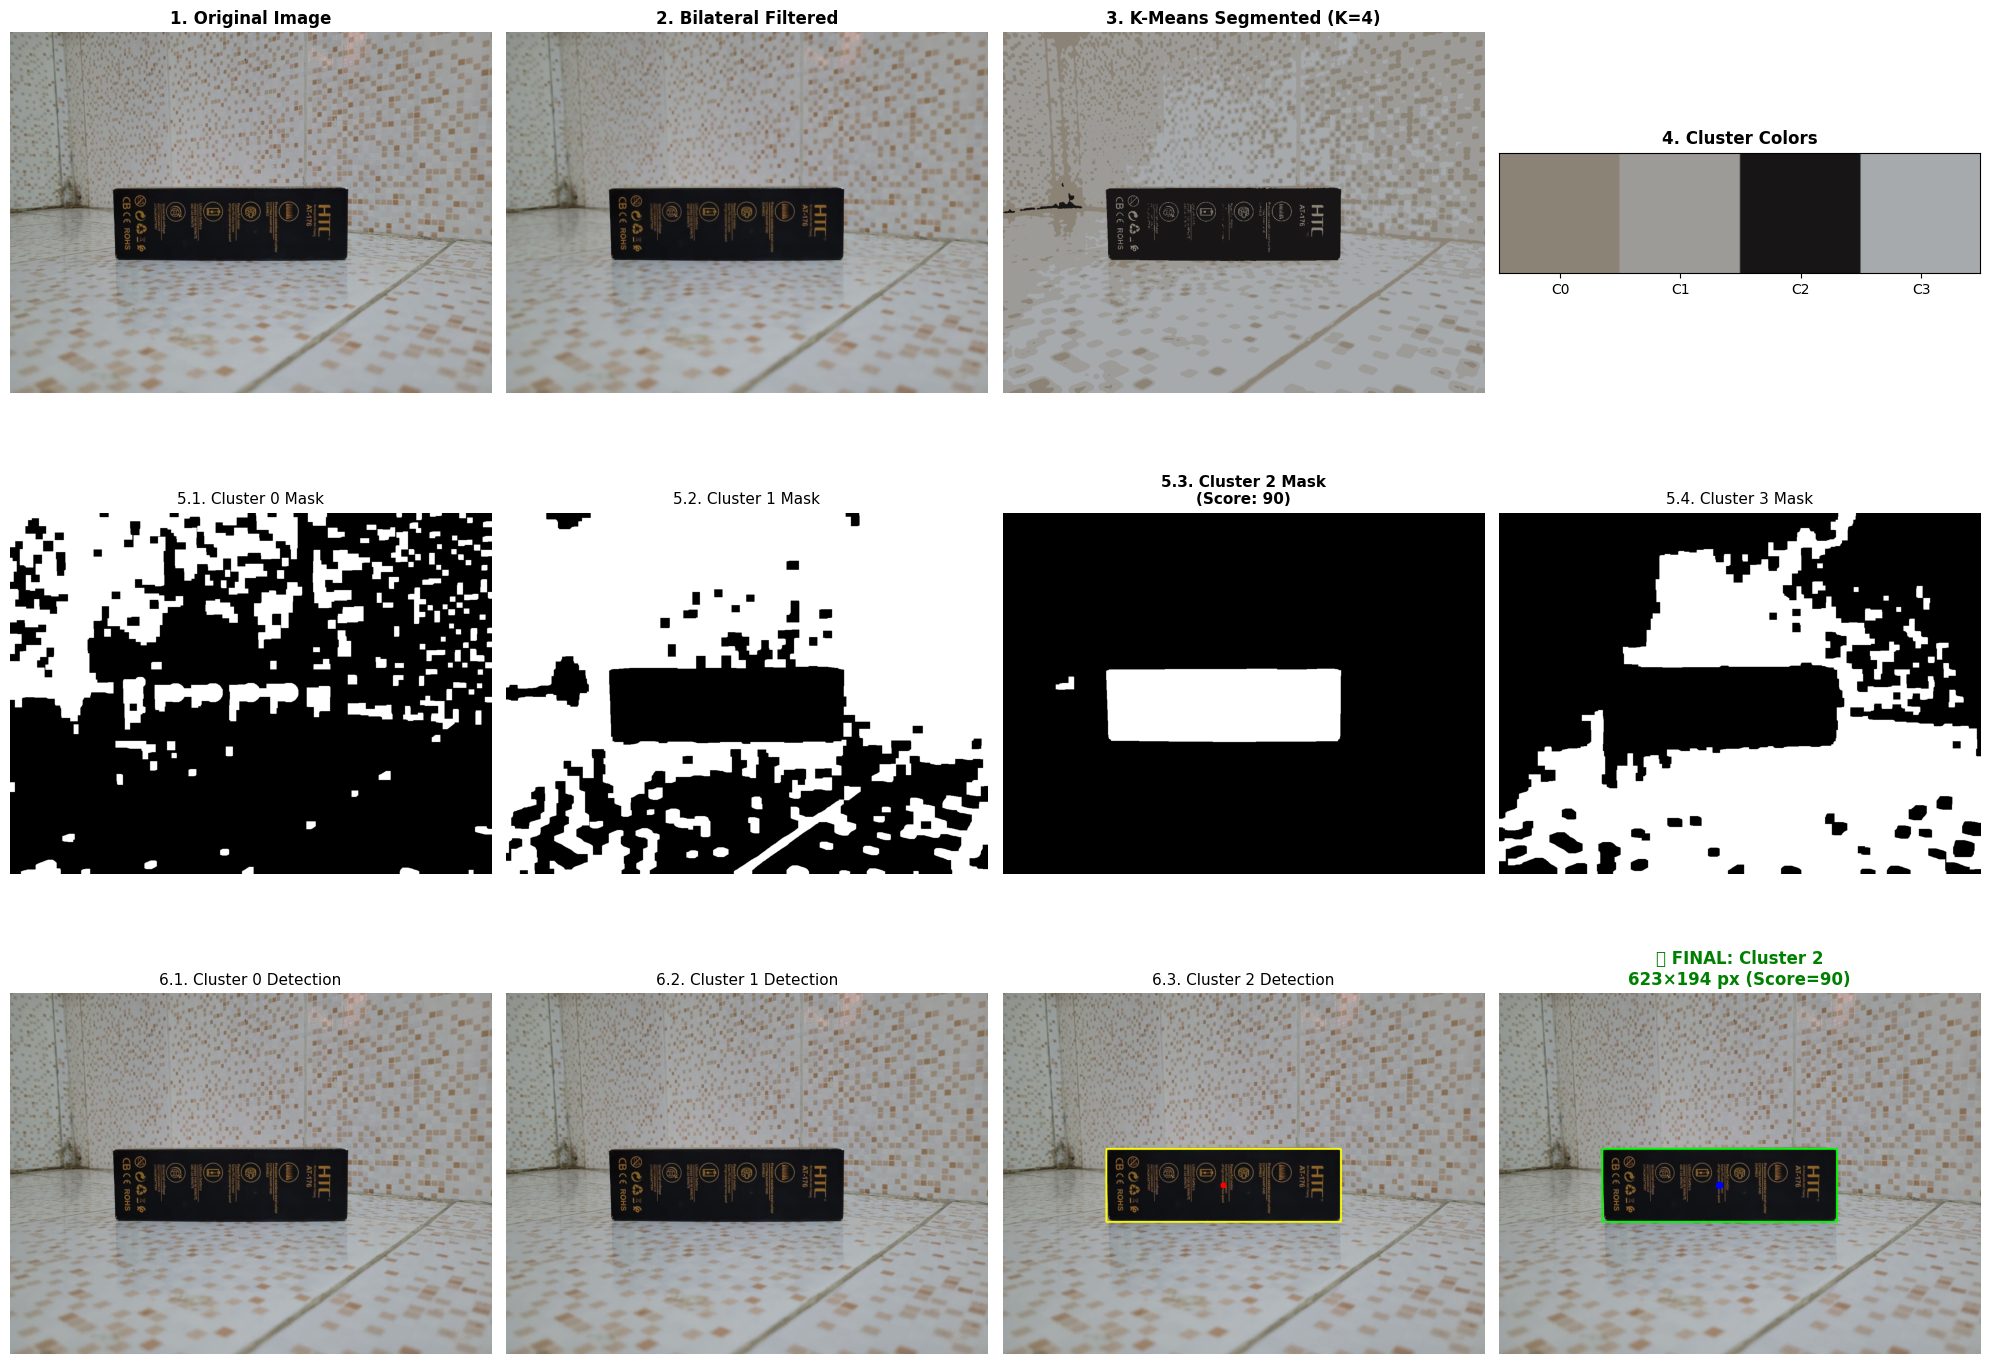



╔════════════════════════════════════════════════════════════╗
║                  📦 MEASUREMENT RESULTS                  ║
╠════════════════════════════════════════════════════════════╣
║  PPC:          35.21 px/cm                             ║
╠════════════════════════════════════════════════════════════╣
║  FRONT FACE:   281 × 194 px  →  7.99 × 5.50 cm     ║
║  SIDE FACE:    623 × 194 px  →  17.69 × 5.51 cm     ║
╠════════════════════════════════════════════════════════════╣
║  Length (L):   7.99 cm                                  ║
║  Width (W):    17.69 cm                                 ║
║  Height (H):   5.50 cm  (avg of 5.50 and 5.51)     ║
╠════════════════════════════════════════════════════════════╣
║  📦 VOLUME:    777.85 cm³                             ║
╠════════════════════════════════════════════════════════════╣
║  REAL:         8.2 × 18.4 × 5.5 cm = 829.8 cm³          ║
╠════════════════════════════════════════════════════════════╣
║  ERROR L:      2.6%              

In [ ]:
# ==================== RUN MEASUREMENT ====================

RESULTS = None

if PPC is None:
    print("❌ PPC not set! Run calibration first.")
else:
    img_front = cv2.imread(IMAGE_FRONT)
    img_side = cv2.imread(IMAGE_SIDE)

    if img_front is None:
        print(f"❌ Cannot load: {IMAGE_FRONT}")
    elif img_side is None:
        print(f"❌ Cannot load: {IMAGE_SIDE}")
    else:
        # Detect FRONT face
        print("\n" + "#"*70)
        print("#" + " "*25 + "FRONT FACE" + " "*25 + "#")
        print("#"*70)
        front_det = detect_box_kmeans(img_front, k=K_MEASURE, visualize=True)

        # Detect SIDE face
        print("\n" + "#"*70)
        print("#" + " "*25 + "SIDE FACE" + " "*26 + "#")
        print("#"*70)
        side_det = detect_box_kmeans(img_side, k=K_MEASURE, visualize=True)

        if front_det and side_det:
            # Convert pixels to cm
            L_cm = front_det['width_px'] / PPC
            H1_cm = front_det['height_px'] / PPC
            W_cm = side_det['width_px'] / PPC
            H2_cm = side_det['height_px'] / PPC
            H_cm = (H1_cm + H2_cm) / 2
            Volume = L_cm * W_cm * H_cm

            # Calculate errors if real values provided
            if REAL_L and REAL_W and REAL_H:
                real_vol = REAL_L * REAL_W * REAL_H
                err_L = abs(L_cm - REAL_L) / REAL_L * 100
                err_W = abs(W_cm - REAL_W) / REAL_W * 100
                err_H = abs(H_cm - REAL_H) / REAL_H * 100
                err_V = abs(Volume - real_vol) / real_vol * 100
            else:
                real_vol = err_L = err_W = err_H = err_V = None

            # Store results
            RESULTS = {
                'L_cm': L_cm, 'W_cm': W_cm, 'H_cm': H_cm,
                'H1_cm': H1_cm, 'H2_cm': H2_cm, 'Volume': Volume,
                'REAL_L': REAL_L, 'REAL_W': REAL_W, 'REAL_H': REAL_H,
                'real_vol': real_vol,
                'err_L': err_L, 'err_W': err_W, 'err_H': err_H, 'err_V': err_V,
                'img_front': img_front, 'img_side': img_side,
                'front_det': front_det, 'side_det': side_det,
                'PPC': PPC
            }

            # Print results
            print("\n")
            print("╔" + "═"*60 + "╗")
            print("║" + " "*18 + "📦 MEASUREMENT RESULTS" + " "*18 + "║")
            print("╠" + "═"*60 + "╣")
            print(f"║  PPC:          {PPC:.2f} px/cm" + " "*(60-26-len(f"{PPC:.2f}")) + "║")
            print("╠" + "═"*60 + "╣")
            print(f"║  FRONT FACE:   {front_det['width_px']:.0f} × {front_det['height_px']:.0f} px  →  {L_cm:.2f} × {H1_cm:.2f} cm" + " "*5 + "║")
            print(f"║  SIDE FACE:    {side_det['width_px']:.0f} × {side_det['height_px']:.0f} px  →  {W_cm:.2f} × {H2_cm:.2f} cm" + " "*5 + "║")
            print("╠" + "═"*60 + "╣")
            print(f"║  Length (L):   {L_cm:.2f} cm" + " "*(60-22-len(f"{L_cm:.2f}")) + "║")
            print(f"║  Width (W):    {W_cm:.2f} cm" + " "*(60-22-len(f"{W_cm:.2f}")) + "║")
            print(f"║  Height (H):   {H_cm:.2f} cm  (avg of {H1_cm:.2f} and {H2_cm:.2f})" + " "*5 + "║")
            print("╠" + "═"*60 + "╣")
            print(f"║  📦 VOLUME:    {Volume:.2f} cm³" + " "*(60-25-len(f"{Volume:.2f}")) + "║")
            print("╠" + "═"*60 + "╣")

            if REAL_L and REAL_W and REAL_H:
                print(f"║  REAL:         {REAL_L} × {REAL_W} × {REAL_H} cm = {real_vol:.1f} cm³" + " "*10 + "║")
                print("╠" + "═"*60 + "╣")
                print(f"║  ERROR L:      {err_L:.1f}%" + " "*(60-20-len(f"{err_L:.1f}")) + "║")
                print(f"║  ERROR W:      {err_W:.1f}%" + " "*(60-20-len(f"{err_W:.1f}")) + "║")
                print(f"║  ERROR H:      {err_H:.1f}%" + " "*(60-20-len(f"{err_H:.1f}")) + "║")
                print(f"║  ERROR V:      {err_V:.1f}%" + " "*(60-20-len(f"{err_V:.1f}")) + "║")

            print("╚" + "═"*60 + "╝")
        else:
            print("\n❌ Detection failed on one or both images.")
            print("   Try different K value (3, 4, 5) or use different images.")

---
## 📊 PART 3: Visualization

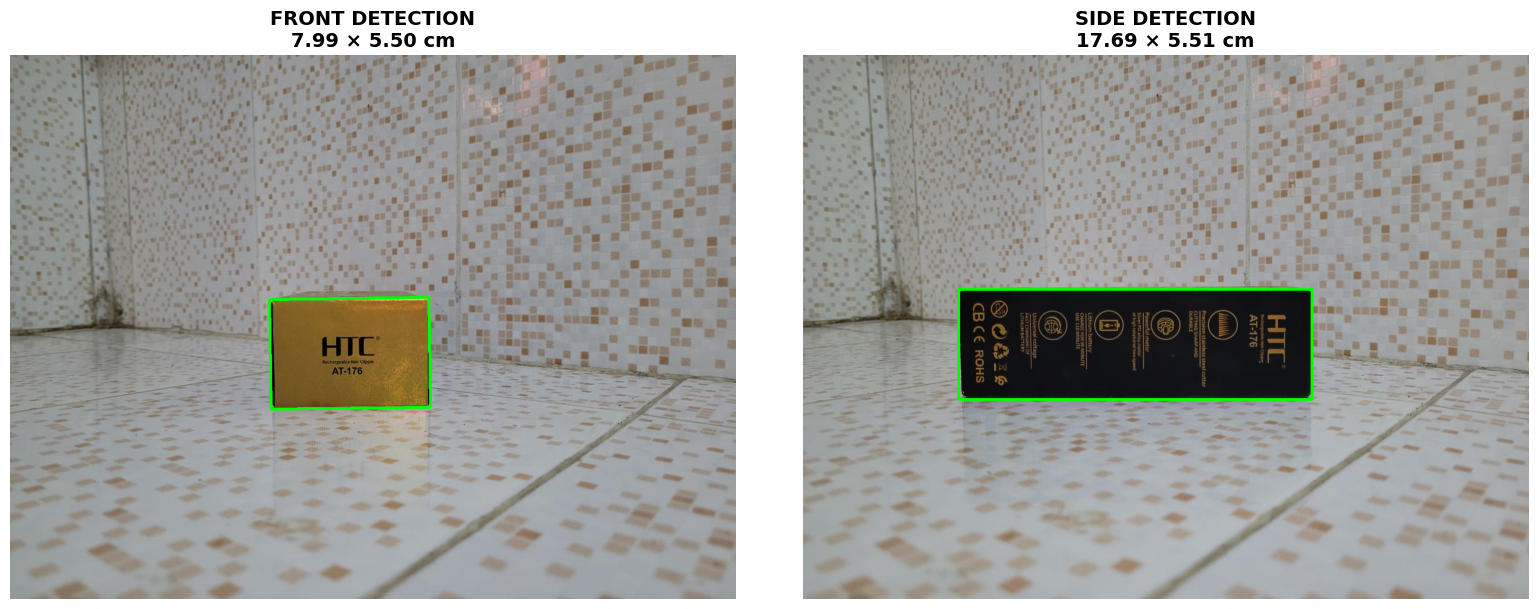

/tmp/ipython-input-2717034242.py:76: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2717034242.py:76: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2717034242.py:76: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2717034242.py:76: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151:

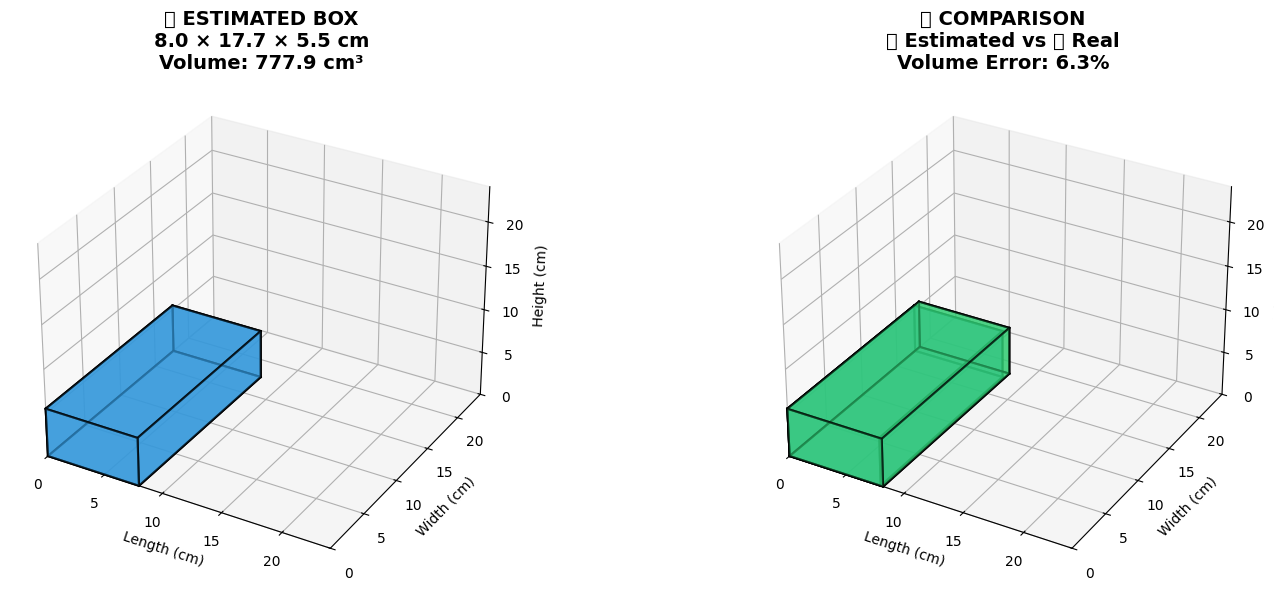

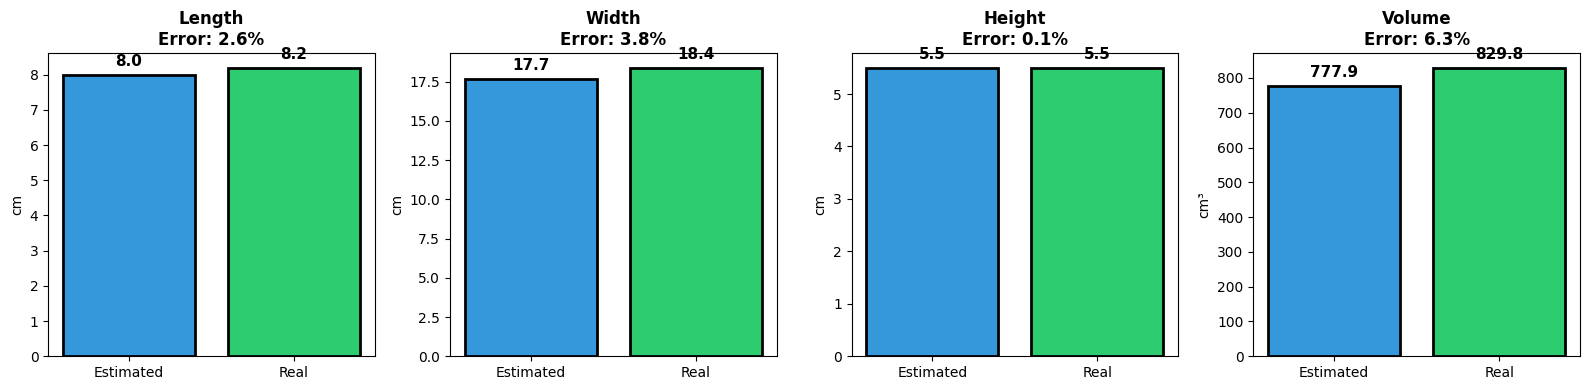


✅ Visualization complete!


In [ ]:
# ==================== 3D VISUALIZATION ====================

def draw_box_3d(ax, L, W, H, color='#3498db', alpha=0.7):
    """Draw a 3D box."""
    v = np.array([[0,0,0],[L,0,0],[L,W,0],[0,W,0],[0,0,H],[L,0,H],[L,W,H],[0,W,H]])
    faces = [[v[0],v[1],v[5],v[4]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]],
             [v[1],v[2],v[6],v[5]], [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]]]
    ax.add_collection3d(Poly3DCollection(faces, alpha=alpha, facecolor=color, edgecolor='black', linewidth=1.5))
    for e in [[0,1],[1,2],[2,3],[3,0],[4,5],[5,6],[6,7],[7,4],[0,4],[1,5],[2,6],[3,7]]:
        ax.plot3D(*zip(v[e[0]], v[e[1]]), color='black', linewidth=1.5)

if RESULTS is None:
    print("⚠️ No results! Run measurement first.")
else:
    L_cm = RESULTS['L_cm']
    W_cm = RESULTS['W_cm']
    H_cm = RESULTS['H_cm']
    Volume = RESULTS['Volume']
    front_det = RESULTS['front_det']
    side_det = RESULTS['side_det']

    # ===== Detection images =====
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Front
    img_f = RESULTS['img_front'].copy()
    cv2.drawContours(img_f, [front_det['contour']], -1, (0, 255, 0), 4)
    axes[0].imshow(cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'FRONT DETECTION\n{L_cm:.2f} × {RESULTS["H1_cm"]:.2f} cm', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Side
    img_s = RESULTS['img_side'].copy()
    cv2.drawContours(img_s, [side_det['contour']], -1, (0, 255, 0), 4)
    axes[1].imshow(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'SIDE DETECTION\n{W_cm:.2f} × {RESULTS["H2_cm"]:.2f} cm', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # ===== 3D Box visualization =====
    fig = plt.figure(figsize=(16, 6))

    max_dim = max(L_cm, W_cm, H_cm)
    if RESULTS.get('REAL_L'):
        max_dim = max(max_dim, RESULTS['REAL_L'], RESULTS['REAL_W'], RESULTS['REAL_H'])
    max_dim *= 1.3

    # Estimated box
    ax1 = fig.add_subplot(121, projection='3d')
    draw_box_3d(ax1, L_cm, W_cm, H_cm, '#3498db', 0.7)
    ax1.set_xlabel('Length (cm)')
    ax1.set_ylabel('Width (cm)')
    ax1.set_zlabel('Height (cm)')
    ax1.set_title(f'📦 ESTIMATED BOX\n{L_cm:.1f} × {W_cm:.1f} × {H_cm:.1f} cm\nVolume: {Volume:.1f} cm³',
                  fontsize=14, fontweight='bold')
    ax1.set_xlim([0, max_dim])
    ax1.set_ylim([0, max_dim])
    ax1.set_zlim([0, max_dim])

    # Comparison with real (if available)
    if RESULTS.get('REAL_L'):
        ax2 = fig.add_subplot(122, projection='3d')
        draw_box_3d(ax2, L_cm, W_cm, H_cm, '#3498db', 0.4)  # Estimated (blue, transparent)
        draw_box_3d(ax2, RESULTS['REAL_L'], RESULTS['REAL_W'], RESULTS['REAL_H'], '#2ecc71', 0.6)  # Real (green)
        ax2.set_xlabel('Length (cm)')
        ax2.set_ylabel('Width (cm)')
        ax2.set_zlabel('Height (cm)')
        ax2.set_title(f'📊 COMPARISON\n🔵 Estimated vs 🟢 Real\nVolume Error: {RESULTS["err_V"]:.1f}%',
                      fontsize=14, fontweight='bold')
        ax2.set_xlim([0, max_dim])
        ax2.set_ylim([0, max_dim])
        ax2.set_zlim([0, max_dim])

    plt.tight_layout()
    plt.show()

    # ===== Bar chart comparison =====
    if RESULTS.get('REAL_L'):
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        data = [
            ('Length', L_cm, RESULTS['REAL_L'], RESULTS['err_L']),
            ('Width', W_cm, RESULTS['REAL_W'], RESULTS['err_W']),
            ('Height', H_cm, RESULTS['REAL_H'], RESULTS['err_H']),
            ('Volume', Volume, RESULTS['real_vol'], RESULTS['err_V'])
        ]

        for ax, (name, est, real, err) in zip(axes, data):
            bars = ax.bar(['Estimated', 'Real'], [est, real],
                         color=['#3498db', '#2ecc71'], edgecolor='black', linewidth=2)
            ax.set_title(f'{name}\nError: {err:.1f}%', fontsize=12, fontweight='bold')
            ax.set_ylabel('cm' if name != 'Volume' else 'cm³')

            for bar, val in zip(bars, [est, real]):
                ax.text(bar.get_x() + bar.get_width()/2, val + 0.02*max(est, real),
                       f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

        plt.tight_layout()
        plt.show()

    print("\n✅ Visualization complete!")

---
## 🔧 Troubleshooting

If detection is wrong, try:
1. **Change K value** - Try K=3, K=4, or K=5
2. **Better lighting** - Reduce shadows
3. **Plain background** - Avoid patterned surfaces
4. **Center the box** - Detection prefers centered objects